<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[09:13:12] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


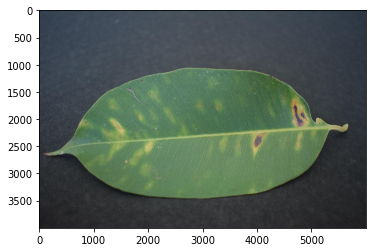

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

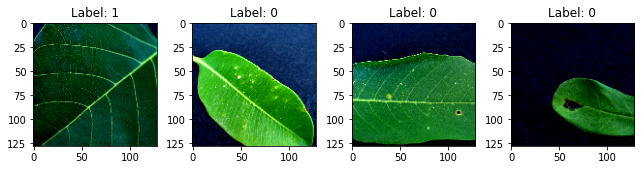

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[09:13:19] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[09:13:21] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2439894882499116 samples/sec                   batch loss = 0.380084365606308 | accuracy = 0.55


Epoch[1] Batch[10] Speed: 1.2667123352727012 samples/sec                   batch loss = 0.5611274838447571 | accuracy = 0.575


Epoch[1] Batch[15] Speed: 1.2577069636726999 samples/sec                   batch loss = 1.6887550354003906 | accuracy = 0.5833333333333334


Epoch[1] Batch[20] Speed: 1.2598452821477935 samples/sec                   batch loss = 1.1479673385620117 | accuracy = 0.5875


Epoch[1] Batch[25] Speed: 1.2624182029075803 samples/sec                   batch loss = 0.8303537368774414 | accuracy = 0.59


Epoch[1] Batch[30] Speed: 1.260261114147524 samples/sec                   batch loss = 0.7718859314918518 | accuracy = 0.575


Epoch[1] Batch[35] Speed: 1.2684506653364123 samples/sec                   batch loss = 0.45410242676734924 | accuracy = 0.5928571428571429


Epoch[1] Batch[40] Speed: 1.2613439045177137 samples/sec                   batch loss = 0.4028654396533966 | accuracy = 0.61875


Epoch[1] Batch[45] Speed: 1.2633238400152769 samples/sec                   batch loss = 0.3546505272388458 | accuracy = 0.6222222222222222


Epoch[1] Batch[50] Speed: 1.2610072519948905 samples/sec                   batch loss = 0.4670296013355255 | accuracy = 0.65


Epoch[1] Batch[55] Speed: 1.2599118876566873 samples/sec                   batch loss = 0.4742162227630615 | accuracy = 0.6545454545454545


Epoch[1] Batch[60] Speed: 1.2593884106680844 samples/sec                   batch loss = 0.8185189962387085 | accuracy = 0.65


Epoch[1] Batch[65] Speed: 1.2668773344464777 samples/sec                   batch loss = 0.25575292110443115 | accuracy = 0.6576923076923077


Epoch[1] Batch[70] Speed: 1.2669577931098228 samples/sec                   batch loss = 0.525269627571106 | accuracy = 0.6535714285714286


Epoch[1] Batch[75] Speed: 1.2640011355295846 samples/sec                   batch loss = 0.7302822470664978 | accuracy = 0.6566666666666666


Epoch[1] Batch[80] Speed: 1.2625076916257996 samples/sec                   batch loss = 0.7913064956665039 | accuracy = 0.65625


Epoch[1] Batch[85] Speed: 1.2662485591956976 samples/sec                   batch loss = 0.628724217414856 | accuracy = 0.6617647058823529


Epoch[1] Batch[90] Speed: 1.2600367919697553 samples/sec                   batch loss = 0.8215765953063965 | accuracy = 0.6555555555555556


Epoch[1] Batch[95] Speed: 1.2594870199510926 samples/sec                   batch loss = 1.3499534130096436 | accuracy = 0.6552631578947369


Epoch[1] Batch[100] Speed: 1.2585997142549568 samples/sec                   batch loss = 0.19002015888690948 | accuracy = 0.6575


Epoch[1] Batch[105] Speed: 1.2612871985470688 samples/sec                   batch loss = 0.49680450558662415 | accuracy = 0.6571428571428571


Epoch[1] Batch[110] Speed: 1.2680225119658306 samples/sec                   batch loss = 1.0631861686706543 | accuracy = 0.6545454545454545


Epoch[1] Batch[115] Speed: 1.2718332994222583 samples/sec                   batch loss = 0.6491727828979492 | accuracy = 0.6543478260869565


Epoch[1] Batch[120] Speed: 1.2654553540321662 samples/sec                   batch loss = 0.4500914514064789 | accuracy = 0.65625


Epoch[1] Batch[125] Speed: 1.2627249112765973 samples/sec                   batch loss = 0.9443926811218262 | accuracy = 0.654


Epoch[1] Batch[130] Speed: 1.270082519099064 samples/sec                   batch loss = 0.9596089720726013 | accuracy = 0.6596153846153846


Epoch[1] Batch[135] Speed: 1.2655308591091627 samples/sec                   batch loss = 0.6586751937866211 | accuracy = 0.6555555555555556


Epoch[1] Batch[140] Speed: 1.2663294159169451 samples/sec                   batch loss = 0.9244250059127808 | accuracy = 0.65


Epoch[1] Batch[145] Speed: 1.2620397736376472 samples/sec                   batch loss = 0.42718803882598877 | accuracy = 0.6517241379310345


Epoch[1] Batch[150] Speed: 1.2655475649894474 samples/sec                   batch loss = 0.4904279112815857 | accuracy = 0.65


Epoch[1] Batch[155] Speed: 1.2729616695287767 samples/sec                   batch loss = 0.7772248387336731 | accuracy = 0.646774193548387


Epoch[1] Batch[160] Speed: 1.2681549727860788 samples/sec                   batch loss = 0.694980800151825 | accuracy = 0.653125


Epoch[1] Batch[165] Speed: 1.27330908483748 samples/sec                   batch loss = 0.5542757511138916 | accuracy = 0.6575757575757576


Epoch[1] Batch[170] Speed: 1.2612376087086445 samples/sec                   batch loss = 0.51589035987854 | accuracy = 0.6588235294117647


Epoch[1] Batch[175] Speed: 1.2728011651021942 samples/sec                   batch loss = 0.31081438064575195 | accuracy = 0.6571428571428571


Epoch[1] Batch[180] Speed: 1.2761160204769222 samples/sec                   batch loss = 0.41810762882232666 | accuracy = 0.6541666666666667


Epoch[1] Batch[185] Speed: 1.2743366918715273 samples/sec                   batch loss = 0.5626063346862793 | accuracy = 0.6554054054054054


Epoch[1] Batch[190] Speed: 1.2718858472699837 samples/sec                   batch loss = 0.758415162563324 | accuracy = 0.656578947368421


Epoch[1] Batch[195] Speed: 1.2704561671761576 samples/sec                   batch loss = 0.891027569770813 | accuracy = 0.6551282051282051


Epoch[1] Batch[200] Speed: 1.2687164652200948 samples/sec                   batch loss = 0.5452706217765808 | accuracy = 0.65375


Epoch[1] Batch[205] Speed: 1.275840901942581 samples/sec                   batch loss = 0.37322184443473816 | accuracy = 0.6548780487804878


Epoch[1] Batch[210] Speed: 1.274819683381936 samples/sec                   batch loss = 0.18517811596393585 | accuracy = 0.6583333333333333


Epoch[1] Batch[215] Speed: 1.269755216718019 samples/sec                   batch loss = 0.6106113791465759 | accuracy = 0.6558139534883721


Epoch[1] Batch[220] Speed: 1.2686821188752773 samples/sec                   batch loss = 0.7675886154174805 | accuracy = 0.6511363636363636


Epoch[1] Batch[225] Speed: 1.2754252953027292 samples/sec                   batch loss = 0.6122719645500183 | accuracy = 0.6511111111111111


Epoch[1] Batch[230] Speed: 1.2731503284559587 samples/sec                   batch loss = 0.40804392099380493 | accuracy = 0.6554347826086957


Epoch[1] Batch[235] Speed: 1.2692373568126234 samples/sec                   batch loss = 0.698455810546875 | accuracy = 0.65


Epoch[1] Batch[240] Speed: 1.27077747826822 samples/sec                   batch loss = 0.5142916440963745 | accuracy = 0.653125


Epoch[1] Batch[245] Speed: 1.2681679136408195 samples/sec                   batch loss = 0.43005046248435974 | accuracy = 0.6561224489795918


Epoch[1] Batch[250] Speed: 1.274516754168126 samples/sec                   batch loss = 0.6553054451942444 | accuracy = 0.658


Epoch[1] Batch[255] Speed: 1.2664943153428334 samples/sec                   batch loss = 0.24459101259708405 | accuracy = 0.6617647058823529


Epoch[1] Batch[260] Speed: 1.2713067109763043 samples/sec                   batch loss = 1.1130526065826416 | accuracy = 0.6644230769230769


Epoch[1] Batch[265] Speed: 1.2677889997653673 samples/sec                   batch loss = 0.5231996774673462 | accuracy = 0.6641509433962264


Epoch[1] Batch[270] Speed: 1.272639156562943 samples/sec                   batch loss = 0.7177445888519287 | accuracy = 0.6611111111111111


Epoch[1] Batch[275] Speed: 1.2710703506448304 samples/sec                   batch loss = 0.5082259774208069 | accuracy = 0.66


Epoch[1] Batch[280] Speed: 1.2691690896210055 samples/sec                   batch loss = 0.7354470491409302 | accuracy = 0.6598214285714286


Epoch[1] Batch[285] Speed: 1.263317085945946 samples/sec                   batch loss = 0.3288303017616272 | accuracy = 0.6596491228070176


Epoch[1] Batch[290] Speed: 1.2627341300365336 samples/sec                   batch loss = 1.2910151481628418 | accuracy = 0.6586206896551724


Epoch[1] Batch[295] Speed: 1.2687064873193372 samples/sec                   batch loss = 0.5549378395080566 | accuracy = 0.6610169491525424


Epoch[1] Batch[300] Speed: 1.2650135770243256 samples/sec                   batch loss = 0.808918833732605 | accuracy = 0.66


Epoch[1] Batch[305] Speed: 1.2681573692207346 samples/sec                   batch loss = 0.544175386428833 | accuracy = 0.6639344262295082


Epoch[1] Batch[310] Speed: 1.2647491355610885 samples/sec                   batch loss = 0.7683297991752625 | accuracy = 0.6661290322580645


Epoch[1] Batch[315] Speed: 1.2655089034801084 samples/sec                   batch loss = 0.20897318422794342 | accuracy = 0.6658730158730158


Epoch[1] Batch[320] Speed: 1.2724600104043522 samples/sec                   batch loss = 0.5848459005355835 | accuracy = 0.665625


Epoch[1] Batch[325] Speed: 1.272585195057181 samples/sec                   batch loss = 0.9675488471984863 | accuracy = 0.6653846153846154


Epoch[1] Batch[330] Speed: 1.2663321877842975 samples/sec                   batch loss = 0.4725904166698456 | accuracy = 0.6666666666666666


Epoch[1] Batch[335] Speed: 1.265242537393631 samples/sec                   batch loss = 0.5300043225288391 | accuracy = 0.667910447761194


Epoch[1] Batch[340] Speed: 1.2667825383633398 samples/sec                   batch loss = 0.40497052669525146 | accuracy = 0.6683823529411764


Epoch[1] Batch[345] Speed: 1.2725191732501513 samples/sec                   batch loss = 0.6626971960067749 | accuracy = 0.6666666666666666


Epoch[1] Batch[350] Speed: 1.2674067697097837 samples/sec                   batch loss = 0.8459025025367737 | accuracy = 0.665


Epoch[1] Batch[355] Speed: 1.2659249489792108 samples/sec                   batch loss = 0.4314337372779846 | accuracy = 0.6647887323943662


Epoch[1] Batch[360] Speed: 1.2619679119623044 samples/sec                   batch loss = 1.8001840114593506 | accuracy = 0.6652777777777777


Epoch[1] Batch[365] Speed: 1.2714514215109198 samples/sec                   batch loss = 0.6805564761161804 | accuracy = 0.6657534246575343


Epoch[1] Batch[370] Speed: 1.2608376191766295 samples/sec                   batch loss = 0.9848499298095703 | accuracy = 0.6648648648648648


Epoch[1] Batch[375] Speed: 1.267698377658632 samples/sec                   batch loss = 0.27058079838752747 | accuracy = 0.6653333333333333


Epoch[1] Batch[380] Speed: 1.2643080419717436 samples/sec                   batch loss = 0.6934613585472107 | accuracy = 0.6651315789473684


Epoch[1] Batch[385] Speed: 1.2636914273533661 samples/sec                   batch loss = 0.22877250611782074 | accuracy = 0.6668831168831169


Epoch[1] Batch[390] Speed: 1.2686266697628916 samples/sec                   batch loss = 0.1883917897939682 | accuracy = 0.6679487179487179


Epoch[1] Batch[395] Speed: 1.2676754846943208 samples/sec                   batch loss = 0.2993623614311218 | accuracy = 0.670253164556962


Epoch[1] Batch[400] Speed: 1.2739276749156414 samples/sec                   batch loss = 0.34746038913726807 | accuracy = 0.67125


Epoch[1] Batch[405] Speed: 1.2646453155395296 samples/sec                   batch loss = 0.5423012375831604 | accuracy = 0.6709876543209876


Epoch[1] Batch[410] Speed: 1.2603412079918592 samples/sec                   batch loss = 0.630822479724884 | accuracy = 0.6725609756097561


Epoch[1] Batch[415] Speed: 1.2716618982801822 samples/sec                   batch loss = 1.247474193572998 | accuracy = 0.672289156626506


Epoch[1] Batch[420] Speed: 1.269493880485693 samples/sec                   batch loss = 0.37780773639678955 | accuracy = 0.6738095238095239


Epoch[1] Batch[425] Speed: 1.2636087182079627 samples/sec                   batch loss = 1.002845048904419 | accuracy = 0.6729411764705883


Epoch[1] Batch[430] Speed: 1.2638643044402522 samples/sec                   batch loss = 0.5728627443313599 | accuracy = 0.6726744186046512


Epoch[1] Batch[435] Speed: 1.2717187698028403 samples/sec                   batch loss = 0.6403900384902954 | accuracy = 0.6735632183908046


Epoch[1] Batch[440] Speed: 1.266646252007492 samples/sec                   batch loss = 1.3567137718200684 | accuracy = 0.6727272727272727


Epoch[1] Batch[445] Speed: 1.2705763390938818 samples/sec                   batch loss = 0.7939616441726685 | accuracy = 0.6735955056179775


Epoch[1] Batch[450] Speed: 1.2650817794676485 samples/sec                   batch loss = 0.20911622047424316 | accuracy = 0.6755555555555556


Epoch[1] Batch[455] Speed: 1.2628124474054456 samples/sec                   batch loss = 0.28867948055267334 | accuracy = 0.6763736263736264


Epoch[1] Batch[460] Speed: 1.2744917747455 samples/sec                   batch loss = 0.5685317516326904 | accuracy = 0.6766304347826086


Epoch[1] Batch[465] Speed: 1.2688795877741088 samples/sec                   batch loss = 0.7928311228752136 | accuracy = 0.6774193548387096


Epoch[1] Batch[470] Speed: 1.2677079565501468 samples/sec                   batch loss = 0.35343337059020996 | accuracy = 0.6776595744680851


Epoch[1] Batch[475] Speed: 1.2660523859878927 samples/sec                   batch loss = 0.6400230526924133 | accuracy = 0.6773684210526316


Epoch[1] Batch[480] Speed: 1.2678854796070083 samples/sec                   batch loss = 0.5927901268005371 | accuracy = 0.6776041666666667


Epoch[1] Batch[485] Speed: 1.2689457123317365 samples/sec                   batch loss = 0.4202457070350647 | accuracy = 0.6778350515463918


Epoch[1] Batch[490] Speed: 1.2661133431927456 samples/sec                   batch loss = 0.5599295496940613 | accuracy = 0.6780612244897959


Epoch[1] Batch[495] Speed: 1.2683467161832365 samples/sec                   batch loss = 0.3465762138366699 | accuracy = 0.6782828282828283


Epoch[1] Batch[500] Speed: 1.2663866717783434 samples/sec                   batch loss = 0.3932490944862366 | accuracy = 0.679


Epoch[1] Batch[505] Speed: 1.2702503209655687 samples/sec                   batch loss = 0.2225116789340973 | accuracy = 0.6782178217821783


Epoch[1] Batch[510] Speed: 1.2665381045505175 samples/sec                   batch loss = 0.5424778461456299 | accuracy = 0.6774509803921569


Epoch[1] Batch[515] Speed: 1.2637971851967467 samples/sec                   batch loss = 0.28371140360832214 | accuracy = 0.6781553398058252


Epoch[1] Batch[520] Speed: 1.2694256817466625 samples/sec                   batch loss = 0.3071294128894806 | accuracy = 0.6783653846153846


Epoch[1] Batch[525] Speed: 1.2643775976607394 samples/sec                   batch loss = 0.4922541379928589 | accuracy = 0.6780952380952381


Epoch[1] Batch[530] Speed: 1.2662678644720622 samples/sec                   batch loss = 0.6346649527549744 | accuracy = 0.6778301886792453


Epoch[1] Batch[535] Speed: 1.2775864929845588 samples/sec                   batch loss = 0.6842765808105469 | accuracy = 0.6780373831775701


Epoch[1] Batch[540] Speed: 1.271127169267985 samples/sec                   batch loss = 0.80722576379776 | accuracy = 0.6773148148148148


Epoch[1] Batch[545] Speed: 1.2696757475907727 samples/sec                   batch loss = 0.7098090648651123 | accuracy = 0.676605504587156


Epoch[1] Batch[550] Speed: 1.2619350690602884 samples/sec                   batch loss = 0.2779557406902313 | accuracy = 0.6777272727272727


Epoch[1] Batch[555] Speed: 1.2719237422657919 samples/sec                   batch loss = 0.4384242296218872 | accuracy = 0.6774774774774774


Epoch[1] Batch[560] Speed: 1.2770527004860153 samples/sec                   batch loss = 0.8657868504524231 | accuracy = 0.6767857142857143


Epoch[1] Batch[565] Speed: 1.2642832705608231 samples/sec                   batch loss = 0.3905321955680847 | accuracy = 0.6787610619469027


Epoch[1] Batch[570] Speed: 1.2684913290505953 samples/sec                   batch loss = 0.4456494450569153 | accuracy = 0.6802631578947368


Epoch[1] Batch[575] Speed: 1.2611494375565422 samples/sec                   batch loss = 0.5913494825363159 | accuracy = 0.68


Epoch[1] Batch[580] Speed: 1.270685658516014 samples/sec                   batch loss = 0.8712134957313538 | accuracy = 0.6801724137931034


Epoch[1] Batch[585] Speed: 1.2712695270380552 samples/sec                   batch loss = 0.4103325307369232 | accuracy = 0.6820512820512821


Epoch[1] Batch[590] Speed: 1.272512320501808 samples/sec                   batch loss = 0.38903602957725525 | accuracy = 0.6826271186440678


Epoch[1] Batch[595] Speed: 1.2633013901482586 samples/sec                   batch loss = 1.0458917617797852 | accuracy = 0.6836134453781513


Epoch[1] Batch[600] Speed: 1.2684666811579137 samples/sec                   batch loss = 0.7184917330741882 | accuracy = 0.6841666666666667


Epoch[1] Batch[605] Speed: 1.2682554390955703 samples/sec                   batch loss = 1.1434723138809204 | accuracy = 0.6838842975206612


Epoch[1] Batch[610] Speed: 1.2663945102123586 samples/sec                   batch loss = 0.28214868903160095 | accuracy = 0.6852459016393443


Epoch[1] Batch[615] Speed: 1.2603523802827143 samples/sec                   batch loss = 0.3266437351703644 | accuracy = 0.6853658536585366


Epoch[1] Batch[620] Speed: 1.264281841470578 samples/sec                   batch loss = 0.4239228665828705 | accuracy = 0.6858870967741936


Epoch[1] Batch[625] Speed: 1.2673319022243024 samples/sec                   batch loss = 0.3821086883544922 | accuracy = 0.686


Epoch[1] Batch[630] Speed: 1.2721261764285947 samples/sec                   batch loss = 0.10881936550140381 | accuracy = 0.6865079365079365


Epoch[1] Batch[635] Speed: 1.2706061691122699 samples/sec                   batch loss = 0.4225955605506897 | accuracy = 0.6881889763779527


Epoch[1] Batch[640] Speed: 1.2650488696782691 samples/sec                   batch loss = 1.5620455741882324 | accuracy = 0.688671875


Epoch[1] Batch[645] Speed: 1.2621034782137053 samples/sec                   batch loss = 0.3122546374797821 | accuracy = 0.6891472868217055


Epoch[1] Batch[650] Speed: 1.264300610446544 samples/sec                   batch loss = 0.421255499124527 | accuracy = 0.6873076923076923


Epoch[1] Batch[655] Speed: 1.2686363586181697 samples/sec                   batch loss = 0.5027269721031189 | accuracy = 0.6877862595419847


Epoch[1] Batch[660] Speed: 1.2646970804168736 samples/sec                   batch loss = 0.63803631067276 | accuracy = 0.6878787878787879


Epoch[1] Batch[665] Speed: 1.2678077772132905 samples/sec                   batch loss = 0.5337659120559692 | accuracy = 0.6879699248120301


Epoch[1] Batch[670] Speed: 1.2725867395089367 samples/sec                   batch loss = 0.6965951323509216 | accuracy = 0.6880597014925374


Epoch[1] Batch[675] Speed: 1.2706387912841526 samples/sec                   batch loss = 0.7024476528167725 | accuracy = 0.6874074074074074


Epoch[1] Batch[680] Speed: 1.2689389939924904 samples/sec                   batch loss = 0.18241915106773376 | accuracy = 0.6882352941176471


Epoch[1] Batch[685] Speed: 1.2779523045120726 samples/sec                   batch loss = 0.23878559470176697 | accuracy = 0.6894160583941605


Epoch[1] Batch[690] Speed: 1.2694433550826527 samples/sec                   batch loss = 0.7155531644821167 | accuracy = 0.688768115942029


Epoch[1] Batch[695] Speed: 1.2762528961028499 samples/sec                   batch loss = 0.11787711828947067 | accuracy = 0.689568345323741


Epoch[1] Batch[700] Speed: 1.2693434687834577 samples/sec                   batch loss = 0.6495842933654785 | accuracy = 0.6892857142857143


Epoch[1] Batch[705] Speed: 1.2759811150837705 samples/sec                   batch loss = 0.2528994083404541 | accuracy = 0.6893617021276596


Epoch[1] Batch[710] Speed: 1.2687386282341944 samples/sec                   batch loss = 0.5304405689239502 | accuracy = 0.6908450704225352


Epoch[1] Batch[715] Speed: 1.2663420327905677 samples/sec                   batch loss = 0.2139897346496582 | accuracy = 0.6912587412587412


Epoch[1] Batch[720] Speed: 1.275868651024872 samples/sec                   batch loss = 0.5159189701080322 | accuracy = 0.6916666666666667


Epoch[1] Batch[725] Speed: 1.2755601801651386 samples/sec                   batch loss = 0.44458693265914917 | accuracy = 0.6920689655172414


Epoch[1] Batch[730] Speed: 1.273966755795859 samples/sec                   batch loss = 0.674252450466156 | accuracy = 0.6921232876712329


Epoch[1] Batch[735] Speed: 1.2618753677006485 samples/sec                   batch loss = 0.304881751537323 | accuracy = 0.6918367346938775


Epoch[1] Batch[740] Speed: 1.2627320391719619 samples/sec                   batch loss = 0.626567006111145 | accuracy = 0.691554054054054


Epoch[1] Batch[745] Speed: 1.2645974630136196 samples/sec                   batch loss = 0.2129969298839569 | accuracy = 0.6912751677852349


Epoch[1] Batch[750] Speed: 1.2753466660342088 samples/sec                   batch loss = 0.3840823173522949 | accuracy = 0.691


Epoch[1] Batch[755] Speed: 1.2668182167579083 samples/sec                   batch loss = 0.22201953828334808 | accuracy = 0.6920529801324503


Epoch[1] Batch[760] Speed: 1.2618245927702902 samples/sec                   batch loss = 0.2978729009628296 | accuracy = 0.6924342105263158


Epoch[1] Batch[765] Speed: 1.2643506320126865 samples/sec                   batch loss = 0.3182344138622284 | accuracy = 0.6931372549019608


Epoch[1] Batch[770] Speed: 1.2685213489840506 samples/sec                   batch loss = 0.5433175563812256 | accuracy = 0.6941558441558442


Epoch[1] Batch[775] Speed: 1.2673121815708577 samples/sec                   batch loss = 0.46180951595306396 | accuracy = 0.6954838709677419


Epoch[1] Batch[780] Speed: 1.2657760502290167 samples/sec                   batch loss = 0.4258175790309906 | accuracy = 0.6955128205128205


Epoch[1] Batch[785] Speed: 1.260917596785284 samples/sec                   batch loss = 0.35712796449661255 | accuracy = 0.6961783439490445


[Epoch 1] training: accuracy=0.6960659898477157
[Epoch 1] time cost: 649.1415519714355
[Epoch 1] validation: validation accuracy=0.7422222222222222


Epoch[2] Batch[5] Speed: 1.26575284466311 samples/sec                   batch loss = 0.46624937653541565 | accuracy = 0.85


Epoch[2] Batch[10] Speed: 1.2653607706254846 samples/sec                   batch loss = 0.25287574529647827 | accuracy = 0.8


Epoch[2] Batch[15] Speed: 1.2641377104972789 samples/sec                   batch loss = 0.5970299243927002 | accuracy = 0.7666666666666667


Epoch[2] Batch[20] Speed: 1.262059425481116 samples/sec                   batch loss = 0.7502363920211792 | accuracy = 0.75


Epoch[2] Batch[25] Speed: 1.2656638501350177 samples/sec                   batch loss = 0.3276338279247284 | accuracy = 0.75


Epoch[2] Batch[30] Speed: 1.2712231946563397 samples/sec                   batch loss = 0.5257152318954468 | accuracy = 0.75


Epoch[2] Batch[35] Speed: 1.2723153596677053 samples/sec                   batch loss = 0.19469423592090607 | accuracy = 0.7571428571428571


Epoch[2] Batch[40] Speed: 1.2622260635304499 samples/sec                   batch loss = 0.2217252552509308 | accuracy = 0.7625


Epoch[2] Batch[45] Speed: 1.2642614534682495 samples/sec                   batch loss = 0.41743117570877075 | accuracy = 0.7555555555555555


Epoch[2] Batch[50] Speed: 1.270514951398904 samples/sec                   batch loss = 0.25695228576660156 | accuracy = 0.735


Epoch[2] Batch[55] Speed: 1.2695328819311786 samples/sec                   batch loss = 0.5349764823913574 | accuracy = 0.7227272727272728


Epoch[2] Batch[60] Speed: 1.268452775181983 samples/sec                   batch loss = 0.8635342121124268 | accuracy = 0.7041666666666667


Epoch[2] Batch[65] Speed: 1.2653649697906204 samples/sec                   batch loss = 0.926914632320404 | accuracy = 0.7115384615384616


Epoch[2] Batch[70] Speed: 1.2597895622105542 samples/sec                   batch loss = 0.561090886592865 | accuracy = 0.725


Epoch[2] Batch[75] Speed: 1.2731971879073551 samples/sec                   batch loss = 0.26263976097106934 | accuracy = 0.7333333333333333


Epoch[2] Batch[80] Speed: 1.2655749635879376 samples/sec                   batch loss = 0.402757465839386 | accuracy = 0.734375


Epoch[2] Batch[85] Speed: 1.2696727688930922 samples/sec                   batch loss = 0.3505200743675232 | accuracy = 0.7382352941176471


Epoch[2] Batch[90] Speed: 1.262896668425581 samples/sec                   batch loss = 0.4306734502315521 | accuracy = 0.7388888888888889


Epoch[2] Batch[95] Speed: 1.2670087906335143 samples/sec                   batch loss = 0.3252219259738922 | accuracy = 0.7394736842105263


Epoch[2] Batch[100] Speed: 1.2665808449722589 samples/sec                   batch loss = 0.36621126532554626 | accuracy = 0.7425


Epoch[2] Batch[105] Speed: 1.2701573272908833 samples/sec                   batch loss = 0.6260846257209778 | accuracy = 0.7357142857142858


Epoch[2] Batch[110] Speed: 1.273630003746369 samples/sec                   batch loss = 0.178137868642807 | accuracy = 0.7386363636363636


Epoch[2] Batch[115] Speed: 1.266354649915605 samples/sec                   batch loss = 0.5488419532775879 | accuracy = 0.7347826086956522


Epoch[2] Batch[120] Speed: 1.2676503895913922 samples/sec                   batch loss = 0.4173828661441803 | accuracy = 0.7333333333333333


Epoch[2] Batch[125] Speed: 1.2704828166325468 samples/sec                   batch loss = 0.41424891352653503 | accuracy = 0.736


Epoch[2] Batch[130] Speed: 1.2736960441758898 samples/sec                   batch loss = 0.4127618074417114 | accuracy = 0.7365384615384616


Epoch[2] Batch[135] Speed: 1.2558477911413606 samples/sec                   batch loss = 1.2007436752319336 | accuracy = 0.7333333333333333


Epoch[2] Batch[140] Speed: 1.2602516474627932 samples/sec                   batch loss = 0.08787819743156433 | accuracy = 0.7392857142857143


Epoch[2] Batch[145] Speed: 1.2679122129653975 samples/sec                   batch loss = 0.7172249555587769 | accuracy = 0.7344827586206897


Epoch[2] Batch[150] Speed: 1.2679112547610298 samples/sec                   batch loss = 0.31384173035621643 | accuracy = 0.7416666666666667


Epoch[2] Batch[155] Speed: 1.2603333496347469 samples/sec                   batch loss = 0.42831096053123474 | accuracy = 0.7387096774193549


Epoch[2] Batch[160] Speed: 1.2602424649144888 samples/sec                   batch loss = 0.2551405429840088 | accuracy = 0.7421875


Epoch[2] Batch[165] Speed: 1.267103237789627 samples/sec                   batch loss = 0.22931945323944092 | accuracy = 0.740909090909091


Epoch[2] Batch[170] Speed: 1.2680490594208287 samples/sec                   batch loss = 0.5160707235336304 | accuracy = 0.7426470588235294


Epoch[2] Batch[175] Speed: 1.2749779843615252 samples/sec                   batch loss = 0.5223379135131836 | accuracy = 0.7385714285714285


Epoch[2] Batch[180] Speed: 1.2698489204266008 samples/sec                   batch loss = 0.4370473325252533 | accuracy = 0.7402777777777778


Epoch[2] Batch[185] Speed: 1.2727955645955726 samples/sec                   batch loss = 0.6213259696960449 | accuracy = 0.7391891891891892


Epoch[2] Batch[190] Speed: 1.2742010978934903 samples/sec                   batch loss = 0.44716617465019226 | accuracy = 0.7421052631578947


Epoch[2] Batch[195] Speed: 1.2722445420145445 samples/sec                   batch loss = 0.2865697741508484 | accuracy = 0.7435897435897436


Epoch[2] Batch[200] Speed: 1.2716784772496261 samples/sec                   batch loss = 0.9661043882369995 | accuracy = 0.74125


Epoch[2] Batch[205] Speed: 1.2661304466604986 samples/sec                   batch loss = 0.5951695442199707 | accuracy = 0.7402439024390244


Epoch[2] Batch[210] Speed: 1.2631446438221903 samples/sec                   batch loss = 0.3984522521495819 | accuracy = 0.7380952380952381


Epoch[2] Batch[215] Speed: 1.2749863170810705 samples/sec                   batch loss = 0.265374094247818 | accuracy = 0.7395348837209302


Epoch[2] Batch[220] Speed: 1.2789876177570931 samples/sec                   batch loss = 0.08642362803220749 | accuracy = 0.7386363636363636


Epoch[2] Batch[225] Speed: 1.2745528695606856 samples/sec                   batch loss = 0.5465893149375916 | accuracy = 0.7344444444444445


Epoch[2] Batch[230] Speed: 1.2674912216578424 samples/sec                   batch loss = 0.22609996795654297 | accuracy = 0.7347826086956522


Epoch[2] Batch[235] Speed: 1.2658552229455695 samples/sec                   batch loss = 0.3182603716850281 | accuracy = 0.7351063829787234


Epoch[2] Batch[240] Speed: 1.2676544124036162 samples/sec                   batch loss = 0.4876435399055481 | accuracy = 0.7354166666666667


Epoch[2] Batch[245] Speed: 1.2745526759070103 samples/sec                   batch loss = 0.4610951542854309 | accuracy = 0.736734693877551


Epoch[2] Batch[250] Speed: 1.268553864188982 samples/sec                   batch loss = 0.31416943669319153 | accuracy = 0.739


Epoch[2] Batch[255] Speed: 1.2675107563641035 samples/sec                   batch loss = 0.22512128949165344 | accuracy = 0.7411764705882353


Epoch[2] Batch[260] Speed: 1.2712627840698132 samples/sec                   batch loss = 0.3736506402492523 | accuracy = 0.7413461538461539


Epoch[2] Batch[265] Speed: 1.2720879800114082 samples/sec                   batch loss = 0.5800321698188782 | accuracy = 0.7405660377358491


Epoch[2] Batch[270] Speed: 1.2778888393457646 samples/sec                   batch loss = 0.30403396487236023 | accuracy = 0.7407407407407407


Epoch[2] Batch[275] Speed: 1.2690270098751677 samples/sec                   batch loss = 0.8176138401031494 | accuracy = 0.740909090909091


Epoch[2] Batch[280] Speed: 1.2637696731272485 samples/sec                   batch loss = 0.5124886631965637 | accuracy = 0.7410714285714286


Epoch[2] Batch[285] Speed: 1.2730607736986617 samples/sec                   batch loss = 0.6384405493736267 | accuracy = 0.7421052631578947


Epoch[2] Batch[290] Speed: 1.269806247484375 samples/sec                   batch loss = 0.382612407207489 | accuracy = 0.7413793103448276


Epoch[2] Batch[295] Speed: 1.2694978189465325 samples/sec                   batch loss = 0.5719744563102722 | accuracy = 0.7389830508474576


Epoch[2] Batch[300] Speed: 1.267665140027706 samples/sec                   batch loss = 0.37751781940460205 | accuracy = 0.7391666666666666


Epoch[2] Batch[305] Speed: 1.2659883776866252 samples/sec                   batch loss = 0.3229963481426239 | accuracy = 0.739344262295082


Epoch[2] Batch[310] Speed: 1.271253825665509 samples/sec                   batch loss = 0.1977275013923645 | accuracy = 0.7403225806451613


Epoch[2] Batch[315] Speed: 1.2659772007813839 samples/sec                   batch loss = 0.5611412525177002 | accuracy = 0.7388888888888889


Epoch[2] Batch[320] Speed: 1.277464213264411 samples/sec                   batch loss = 0.24967658519744873 | accuracy = 0.740625


Epoch[2] Batch[325] Speed: 1.2714277183285423 samples/sec                   batch loss = 0.485306978225708 | accuracy = 0.7423076923076923


Epoch[2] Batch[330] Speed: 1.2680663110704913 samples/sec                   batch loss = 0.6298233866691589 | accuracy = 0.7431818181818182


Epoch[2] Batch[335] Speed: 1.2655221722257175 samples/sec                   batch loss = 0.32456740736961365 | accuracy = 0.7440298507462687


Epoch[2] Batch[340] Speed: 1.27402799377916 samples/sec                   batch loss = 0.47422173619270325 | accuracy = 0.7426470588235294


Epoch[2] Batch[345] Speed: 1.265297404789802 samples/sec                   batch loss = 0.7904183864593506 | accuracy = 0.7427536231884058


Epoch[2] Batch[350] Speed: 1.261803619645827 samples/sec                   batch loss = 0.6549196243286133 | accuracy = 0.7414285714285714


Epoch[2] Batch[355] Speed: 1.266765512920925 samples/sec                   batch loss = 0.2988525927066803 | accuracy = 0.7422535211267606


Epoch[2] Batch[360] Speed: 1.2714279110337787 samples/sec                   batch loss = 0.08497098833322525 | accuracy = 0.7451388888888889


Epoch[2] Batch[365] Speed: 1.2653487458976815 samples/sec                   batch loss = 0.22287549078464508 | accuracy = 0.7458904109589041


Epoch[2] Batch[370] Speed: 1.2618685342010332 samples/sec                   batch loss = 0.42742183804512024 | accuracy = 0.7466216216216216


Epoch[2] Batch[375] Speed: 1.2587556178852188 samples/sec                   batch loss = 0.4815365672111511 | accuracy = 0.7466666666666667


Epoch[2] Batch[380] Speed: 1.2618944449454583 samples/sec                   batch loss = 0.6584053635597229 | accuracy = 0.7453947368421052


Epoch[2] Batch[385] Speed: 1.2692279468336738 samples/sec                   batch loss = 0.3193281292915344 | accuracy = 0.7461038961038962


Epoch[2] Batch[390] Speed: 1.2661657061052671 samples/sec                   batch loss = 0.9622747302055359 | accuracy = 0.7461538461538462


Epoch[2] Batch[395] Speed: 1.2631977125551066 samples/sec                   batch loss = 0.30907654762268066 | accuracy = 0.7462025316455696


Epoch[2] Batch[400] Speed: 1.261627985236052 samples/sec                   batch loss = 0.7974515557289124 | accuracy = 0.744375


Epoch[2] Batch[405] Speed: 1.2633064317862088 samples/sec                   batch loss = 0.21634650230407715 | accuracy = 0.7432098765432099


Epoch[2] Batch[410] Speed: 1.267965874721566 samples/sec                   batch loss = 0.6685028076171875 | accuracy = 0.7445121951219512


Epoch[2] Batch[415] Speed: 1.266339260880116 samples/sec                   batch loss = 0.3171141743659973 | accuracy = 0.744578313253012


Epoch[2] Batch[420] Speed: 1.265958381993666 samples/sec                   batch loss = 0.47474026679992676 | accuracy = 0.7440476190476191


Epoch[2] Batch[425] Speed: 1.2621831417174858 samples/sec                   batch loss = 0.23599593341350555 | accuracy = 0.7423529411764705


Epoch[2] Batch[430] Speed: 1.2676351606049723 samples/sec                   batch loss = 0.21531857550144196 | accuracy = 0.7441860465116279


Epoch[2] Batch[435] Speed: 1.2670240045735224 samples/sec                   batch loss = 0.5385435819625854 | accuracy = 0.7436781609195402


Epoch[2] Batch[440] Speed: 1.2676698334203396 samples/sec                   batch loss = 0.20685707032680511 | accuracy = 0.7454545454545455


Epoch[2] Batch[445] Speed: 1.2623598805720748 samples/sec                   batch loss = 0.3195253014564514 | accuracy = 0.746629213483146


Epoch[2] Batch[450] Speed: 1.2658846406641397 samples/sec                   batch loss = 0.8200218081474304 | accuracy = 0.7461111111111111


Epoch[2] Batch[455] Speed: 1.2692502237443648 samples/sec                   batch loss = 2.250927448272705 | accuracy = 0.7450549450549451


Epoch[2] Batch[460] Speed: 1.2672753266551395 samples/sec                   batch loss = 0.6946322917938232 | accuracy = 0.7451086956521739


Epoch[2] Batch[465] Speed: 1.265634920060157 samples/sec                   batch loss = 0.565452516078949 | accuracy = 0.7440860215053764


Epoch[2] Batch[470] Speed: 1.2604697959953985 samples/sec                   batch loss = 0.18768706917762756 | accuracy = 0.7441489361702127


Epoch[2] Batch[475] Speed: 1.2655909068724316 samples/sec                   batch loss = 0.07239902019500732 | accuracy = 0.7436842105263158


Epoch[2] Batch[480] Speed: 1.2652527471400392 samples/sec                   batch loss = 0.5431970953941345 | accuracy = 0.74375


Epoch[2] Batch[485] Speed: 1.2695781304531677 samples/sec                   batch loss = 1.1850237846374512 | accuracy = 0.743298969072165


Epoch[2] Batch[490] Speed: 1.2614586596213764 samples/sec                   batch loss = 0.22864513099193573 | accuracy = 0.7448979591836735


Epoch[2] Batch[495] Speed: 1.2639115301946815 samples/sec                   batch loss = 0.5470088124275208 | accuracy = 0.7449494949494949


Epoch[2] Batch[500] Speed: 1.267553179392995 samples/sec                   batch loss = 0.3494669198989868 | accuracy = 0.745


Epoch[2] Batch[505] Speed: 1.2665787413493341 samples/sec                   batch loss = 0.7877138257026672 | accuracy = 0.745049504950495


Epoch[2] Batch[510] Speed: 1.2706505318267087 samples/sec                   batch loss = 0.2452908605337143 | accuracy = 0.7450980392156863


Epoch[2] Batch[515] Speed: 1.262244011791225 samples/sec                   batch loss = 0.36556118726730347 | accuracy = 0.7451456310679612


Epoch[2] Batch[520] Speed: 1.263815558976007 samples/sec                   batch loss = 0.29302647709846497 | accuracy = 0.7456730769230769


Epoch[2] Batch[525] Speed: 1.27196318245837 samples/sec                   batch loss = 0.33909687399864197 | accuracy = 0.7466666666666667


Epoch[2] Batch[530] Speed: 1.2689810327710114 samples/sec                   batch loss = 0.20437122881412506 | accuracy = 0.7466981132075472


Epoch[2] Batch[535] Speed: 1.2653195439387623 samples/sec                   batch loss = 0.7166833281517029 | accuracy = 0.7462616822429906


Epoch[2] Batch[540] Speed: 1.2610775824453526 samples/sec                   batch loss = 0.22384008765220642 | accuracy = 0.7476851851851852


Epoch[2] Batch[545] Speed: 1.2637328335814015 samples/sec                   batch loss = 0.3634569048881531 | accuracy = 0.748165137614679


Epoch[2] Batch[550] Speed: 1.272741686377333 samples/sec                   batch loss = 0.08366422355175018 | accuracy = 0.7495454545454545


Epoch[2] Batch[555] Speed: 1.2636755318900537 samples/sec                   batch loss = 0.30680832266807556 | accuracy = 0.75


Epoch[2] Batch[560] Speed: 1.264023800741121 samples/sec                   batch loss = 0.6787806749343872 | accuracy = 0.75


Epoch[2] Batch[565] Speed: 1.2604530345108154 samples/sec                   batch loss = 0.45235997438430786 | accuracy = 0.75


Epoch[2] Batch[570] Speed: 1.2714462182976163 samples/sec                   batch loss = 0.2371138483285904 | accuracy = 0.7508771929824561


Epoch[2] Batch[575] Speed: 1.2648058672003355 samples/sec                   batch loss = 0.06761033833026886 | accuracy = 0.7508695652173913


Epoch[2] Batch[580] Speed: 1.2664116212773737 samples/sec                   batch loss = 0.2924605906009674 | accuracy = 0.7491379310344828


Epoch[2] Batch[585] Speed: 1.2642429714549412 samples/sec                   batch loss = 0.29913243651390076 | accuracy = 0.7495726495726496


Epoch[2] Batch[590] Speed: 1.2602953847355758 samples/sec                   batch loss = 0.3692898154258728 | accuracy = 0.7491525423728813


Epoch[2] Batch[595] Speed: 1.2741813564232853 samples/sec                   batch loss = 0.18598592281341553 | accuracy = 0.7495798319327731


Epoch[2] Batch[600] Speed: 1.2655654169032766 samples/sec                   batch loss = 0.29362431168556213 | accuracy = 0.74875


Epoch[2] Batch[605] Speed: 1.2691527680329218 samples/sec                   batch loss = 0.34087181091308594 | accuracy = 0.75


Epoch[2] Batch[610] Speed: 1.2595393089897606 samples/sec                   batch loss = 0.21700815856456757 | accuracy = 0.7504098360655738


Epoch[2] Batch[615] Speed: 1.2656010267703948 samples/sec                   batch loss = 0.492220014333725 | accuracy = 0.7504065040650406


Epoch[2] Batch[620] Speed: 1.262296719951751 samples/sec                   batch loss = 0.5226588249206543 | accuracy = 0.75


Epoch[2] Batch[625] Speed: 1.2663052342785477 samples/sec                   batch loss = 0.6394819021224976 | accuracy = 0.7488


Epoch[2] Batch[630] Speed: 1.2560974258457605 samples/sec                   batch loss = 0.260156512260437 | accuracy = 0.7484126984126984


Epoch[2] Batch[635] Speed: 1.2563097169067516 samples/sec                   batch loss = 0.5994167327880859 | accuracy = 0.7488188976377953


Epoch[2] Batch[640] Speed: 1.2633700740346265 samples/sec                   batch loss = 0.313766747713089 | accuracy = 0.748828125


Epoch[2] Batch[645] Speed: 1.2689528146534368 samples/sec                   batch loss = 0.5217083096504211 | accuracy = 0.7488372093023256


Epoch[2] Batch[650] Speed: 1.269416365023062 samples/sec                   batch loss = 0.940248966217041 | accuracy = 0.7469230769230769


Epoch[2] Batch[655] Speed: 1.2616504705428675 samples/sec                   batch loss = 0.18150050938129425 | accuracy = 0.7469465648854962


Epoch[2] Batch[660] Speed: 1.2661040750261714 samples/sec                   batch loss = 0.25917139649391174 | accuracy = 0.7481060606060606


Epoch[2] Batch[665] Speed: 1.2657252473817093 samples/sec                   batch loss = 0.3613712191581726 | accuracy = 0.7481203007518797


Epoch[2] Batch[670] Speed: 1.2668075991167722 samples/sec                   batch loss = 0.39419612288475037 | accuracy = 0.7488805970149254


Epoch[2] Batch[675] Speed: 1.2658205538182215 samples/sec                   batch loss = 0.5532988905906677 | accuracy = 0.7488888888888889


Epoch[2] Batch[680] Speed: 1.2644618369875913 samples/sec                   batch loss = 0.40277865529060364 | accuracy = 0.7492647058823529


Epoch[2] Batch[685] Speed: 1.2561949560719288 samples/sec                   batch loss = 0.6610048413276672 | accuracy = 0.7492700729927008


Epoch[2] Batch[690] Speed: 1.26815257636048 samples/sec                   batch loss = 0.9443354606628418 | accuracy = 0.7481884057971014


Epoch[2] Batch[695] Speed: 1.2672580965208144 samples/sec                   batch loss = 1.2776726484298706 | accuracy = 0.7485611510791367


Epoch[2] Batch[700] Speed: 1.2712359092356673 samples/sec                   batch loss = 0.4138682782649994 | accuracy = 0.7485714285714286


Epoch[2] Batch[705] Speed: 1.2628502789344953 samples/sec                   batch loss = 0.6638792157173157 | accuracy = 0.74822695035461


Epoch[2] Batch[710] Speed: 1.2671954019307468 samples/sec                   batch loss = 0.5315068960189819 | accuracy = 0.7485915492957746


Epoch[2] Batch[715] Speed: 1.2690202906750485 samples/sec                   batch loss = 0.6038543581962585 | accuracy = 0.7496503496503496


Epoch[2] Batch[720] Speed: 1.275120624538851 samples/sec                   batch loss = 0.8404148817062378 | accuracy = 0.75


Epoch[2] Batch[725] Speed: 1.2720506539106884 samples/sec                   batch loss = 0.6233600974082947 | accuracy = 0.7503448275862069


Epoch[2] Batch[730] Speed: 1.2636500238385935 samples/sec                   batch loss = 0.31951767206192017 | accuracy = 0.7513698630136987


Epoch[2] Batch[735] Speed: 1.2676964618976998 samples/sec                   batch loss = 0.5740067958831787 | accuracy = 0.7510204081632653


Epoch[2] Batch[740] Speed: 1.2663401211268885 samples/sec                   batch loss = 0.3864991068840027 | accuracy = 0.7510135135135135


Epoch[2] Batch[745] Speed: 1.2745796911632203 samples/sec                   batch loss = 0.5559545159339905 | accuracy = 0.7503355704697987


Epoch[2] Batch[750] Speed: 1.2725024758375922 samples/sec                   batch loss = 0.35063543915748596 | accuracy = 0.7506666666666667


Epoch[2] Batch[755] Speed: 1.2660405391873253 samples/sec                   batch loss = 0.41958439350128174 | accuracy = 0.75


Epoch[2] Batch[760] Speed: 1.2726230352044097 samples/sec                   batch loss = 0.5910223126411438 | accuracy = 0.749671052631579


Epoch[2] Batch[765] Speed: 1.2732435676679983 samples/sec                   batch loss = 0.40286827087402344 | accuracy = 0.7503267973856209


Epoch[2] Batch[770] Speed: 1.2684166210714425 samples/sec                   batch loss = 0.7742791771888733 | accuracy = 0.7503246753246753


Epoch[2] Batch[775] Speed: 1.2624885958345713 samples/sec                   batch loss = 1.170482873916626 | accuracy = 0.75


Epoch[2] Batch[780] Speed: 1.266373576074581 samples/sec                   batch loss = 0.44531720876693726 | accuracy = 0.7509615384615385


Epoch[2] Batch[785] Speed: 1.2652825185562828 samples/sec                   batch loss = 0.3036547303199768 | accuracy = 0.7519108280254777


[Epoch 2] training: accuracy=0.7525380710659898
[Epoch 2] time cost: 640.0246696472168
[Epoch 2] validation: validation accuracy=0.7122222222222222


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7088888888888889

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)